In [16]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [1]:
from instruments import Generator

In [13]:
gen = Generator()

In [14]:
gen.state=True

USBError: [Errno 16] Resource busy

In [16]:
import usbtmc
import numpy as np

class Oscilloscope(usbtmc.Instrument):
    def __init__(self, vendor_id, product_id, timeout=2):
        """
        Initialize the oscilloscope instrument.

        :param vendor_id: The vendor ID of the oscilloscope.
        :param product_id: The product ID of the oscilloscope.
        :param timeout: Communication timeout in seconds.
        """
        super().__init__(vendor_id, product_id)
        self.timeout = timeout
        self.write('*CLS')  # Clear the status
        self.write(':WAV:STREAM ON')  # Enable waveform streaming
        self.write('wav:form ascii')  # Set waveform format to ASCII
        self.write('wav:uns 1')  # Unsigned data format

    def __del__(self):
        self.close()
        return super().__del__()

    def fetch_x_data(self):
        """
        Fetch X-axis data (time data) from the oscilloscope.

        :return: Numpy array of X-axis data (time points).
        """
        x_increment = float(self.ask(":WAV:XINC?"))
        x_origin = float(self.ask(":WAV:XOR?"))
        x_reference = float(self.ask(":WAV:XREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Generate the time (X-axis) data array
        x_data = np.arange(num_points) * x_increment + x_origin - x_reference * x_increment
        return x_data

    def fetch_y_data(self, channel=1):
        """
        Fetch Y-axis data (voltage data) from the oscilloscope for a specified channel.

        :param channel: The channel number to fetch data from (default is 1).
        :return: Numpy array of Y-axis data (voltage points).
        """
        # Set the channel to read from
        self.write(f":WAV:SOUR CHAN{channel}")

        # Get Y data scaling parameters
        y_increment = float(self.ask(":WAV:YINC?"))
        y_origin = float(self.ask(":WAV:YOR?"))
        y_reference = float(self.ask(":WAV:YREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Request the waveform data
        self.write(":WAV:DATA?")
        raw_data = self.read_raw().decode()  # Read and decode raw data as a string
        
        # Process the ASCII data
        # The data typically comes in a comma-separated format
        data_str = raw_data.strip().split(",")[:-1]

        # Convert data to a numpy array of floats
        y_data = np.array([float(value) for value in data_str])

        # Check if we have the expected number of points
        if len(y_data) != num_points:
            raise ValueError(f"Mismatch in data length: expected {num_points}, got {len(y_data)}")

        # Scale the data to get the correct voltage values
        y_data = (y_data - y_reference) * y_increment + y_origin
        return y_data

    def close(self):
        """
        Close the communication with the oscilloscope.
        """
        self.write(":WAV:STREAM OFF")  # Turn off waveform streaming
        super().close()

# Example usage:
# osc = Oscilloscope(vendor_id=0x1234, product_id=0x5678)
# x_data = osc.fetch_x_data()
# y_data = osc.fetch_y_data(channel=1)
# osc.close()


In [33]:
import usbtmc
import numpy as np

class Oscilloscope(usbtmc.Instrument):
    def __init__(self, vendor_id, product_id, timeout=2):
        """
        Initialize the oscilloscope instrument.

        :param vendor_id: The vendor ID of the oscilloscope.
        :param product_id: The product ID of the oscilloscope.
        :param timeout: Communication timeout in seconds.
        """
        super().__init__(vendor_id, product_id)
        self.timeout = timeout
        self.write('*CLS')  # Clear the status
        self.write(':WAV:STREAM ON')  # Enable waveform streaming
        self.write(':WAVeform:BYTeord LSBFirst')
        self.write(':wav:form word')  # Set waveform format to 16-bit word
        # self.write(':wav:uns 1')  # Unsigned data format

    def __del__(self):
        self.close()
        return super().__del__()

    def fetch_x_data(self):
        """
        Fetch X-axis data (time data) from the oscilloscope.

        :return: Numpy array of X-axis data (time points).
        """
        x_increment = float(self.ask(":WAV:XINC?"))
        x_origin = float(self.ask(":WAV:XOR?"))
        x_reference = float(self.ask(":WAV:XREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Generate the time (X-axis) data array
        x_data = np.arange(num_points) * x_increment + x_origin - x_reference * x_increment
        return x_data

    def fetch_y_data(self, channel=1):
        """
        Fetch Y-axis data (voltage data) from the oscilloscope for a specified channel.

        :param channel: The channel number to fetch data from (default is 1).
        :return: Numpy array of Y-axis data (voltage points).
        """
        # Set the channel to read from
        self.write(f":WAV:SOUR CHAN{channel}")

        # Get Y data scaling parameters
        y_increment = float(self.ask(":WAV:YINC?"))
        y_origin = float(self.ask(":WAV:YOR?"))
        y_reference = float(self.ask(":WAV:YREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Request the waveform data
        self.write(":WAV:DATA?")
        raw_data = self.read_raw()  # Read raw data

        # Process the raw data
        header_size = 2  # Standard header size for 16-bit word data
        data_size = len(raw_data) - header_size - 1
        if data_size != num_points * 2:  # 16-bit data means 2 bytes per point
            raise ValueError(f"Mismatch in data length: expected {num_points * 2}, got {data_size}")

        # return raw_data

        # Convert raw data to a numpy array of 16-bit unsigned integers
        y_data = np.frombuffer(raw_data[header_size:-1], dtype=np.int16)

        # Scale the data to get the correct voltage values
        y_data = (y_data - y_reference) * y_increment + y_origin
        return y_data

    def close(self):
        """
        Close the communication with the oscilloscope.
        """
        self.write(":WAV:STREAM OFF")  # Turn off waveform streaming
        super().close()

# Example usage:
# osc = Oscilloscope(vendor_id=0x1234, product_id=0x5678)
# x_data = osc.fetch_x_data()
# y_data = osc.fetch_y_data(channel=1)
# osc.close()


In [ ]:
scope.close()
scope = Oscilloscope(vendor_id=0x0957, product_id=0x900d)

In [54]:
x=scope.fetch_x_data()

In [55]:
y=scope.fetch_y_data()

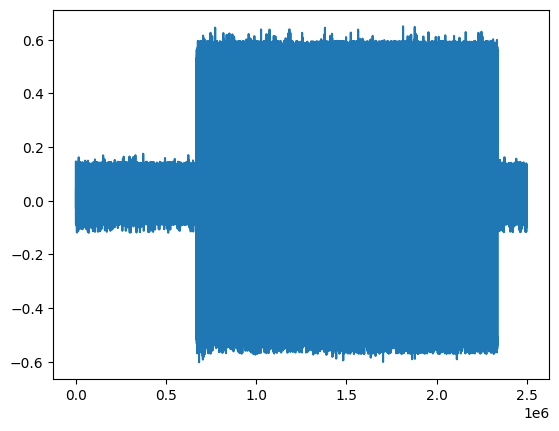

In [63]:
plot(y)

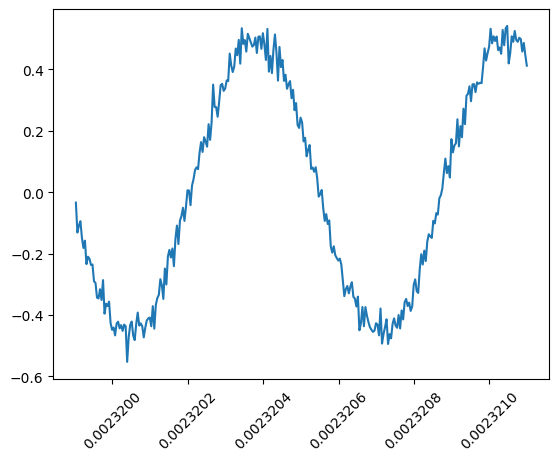

In [67]:
plt.xticks(rotation=45)
plot(x[2500002//2:2500002//2+300], y[2500002//2:2500002//2+300])

In [70]:
len(y)

2500002